
# Case Study

In [ ]:

import os, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

OUT_DIR = "part2_redo_outputs"
os.makedirs(OUT_DIR, exist_ok=True)

pd.set_option("display.max_columns", 100)


In [ ]:

# Load data
CSV_PATH = "NFLX.csv"
df_raw = pd.read_csv(CSV_PATH)

date_col = None
for cand in ["Date","date","DATE"]:
    if cand in df_raw.columns:
        date_col = cand; break
assert date_col is not None, "No Date column found in NFLX.csv"

df_raw[date_col] = pd.to_datetime(df_raw[date_col])
df = df_raw.sort_values(date_col).set_index(date_col).copy()


rename_map = {}
for c in df.columns:
    lc = c.lower()
    if lc in ["adj close","adj_close","adjusted close"]: rename_map[c]="AdjClose"
    elif lc=="close": rename_map[c]="Close"
    elif lc=="open": rename_map[c]="Open"
    elif lc=="high": rename_map[c]="High"
    elif lc=="low": rename_map[c]="Low"
    elif lc=="volume": rename_map[c]="Volume"
df = df.rename(columns=rename_map)

cols = [c for c in ["Open","High","Low","Close","AdjClose","Volume"] if c in df.columns]
df = df[cols].copy()
df.to_csv(os.path.join(OUT_DIR, "clean_ohlcv.csv"))
df.head()


,Open,High,Low,Close,AdjClose,Volume
Date,,,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


In [ ]:

# Data dictionary & quality checks
dtypes = df.dtypes.to_frame("dtype")
missing = df.isna().sum().to_frame("missing")
summary = df.describe().T

data_dict = dtypes.join(missing).join(summary)
data_dict.to_csv(os.path.join(OUT_DIR, "data_dictionary.csv"))
data_dict


,dtype,missing,count,mean,std,min,25%,50%,75%,max
Open,float64,0,4874.0,1.046448e+02,1.558867e+02,0.377857,3.901429e+00,2.138643e+01,1.254450e+02,6.080500e+02
High,float64,0,4874.0,1.062437e+02,1.581732e+02,0.410714,3.977143e+00,2.181643e+01,1.265925e+02,6.190000e+02
Low,float64,0,4874.0,1.030067e+02,1.535470e+02,0.346429,3.835357e+00,2.093571e+01,1.229875e+02,6.080500e+02
Close,float64,0,4874.0,1.046865e+02,1.559404e+02,0.372857,3.905714e+00,2.123357e+01,1.250975e+02,6.103400e+02
AdjClose,float64,0,4874.0,1.046865e+02,1.559404e+02,0.372857,3.905714e+00,2.123357e+01,1.250975e+02,6.103400e+02
Volume,int64,0,4874.0,1.681687e+07,1.937625e+07,285600.000000,6.301225e+06,1.084630e+07,2.016192e+07,3.234140e+08


In [ ]:

# EDA features (no future leakage: all rolling/lagged)
df["Ret_close2close"] = df["AdjClose"].pct_change()
df["Ret_log"] = np.log(df["AdjClose"]).diff()
df["Lag1"] = df["AdjClose"].shift(1)
df["SMA_20"] = df["AdjClose"].rolling(20).mean()
df["SMA_200"] = df["AdjClose"].rolling(200).mean()
df["RollingVol_20"] = df["Ret_close2close"].rolling(20).std()
df["Range_Pct"] = (df["High"] - df["Low"]) / df["Open"]

# Regime labels by year (for quick group comparisons)
df["Year"] = df.index.year
df["BigMove"] = (df["AdjClose"].pct_change().abs() >= 0.03).astype(int)

df_eda = df.copy()
df_eda.to_csv(os.path.join(OUT_DIR, "eda_features.csv"))
df_eda.tail()


,Open,High,Low,Close,AdjClose,Volume,Ret_close2close,Ret_log,Lag1,SMA_20,SMA_200,RollingVol_20,Range_Pct,Year,BigMove
Date,,,,,,,,,,,,,,,
2021-09-24,592.500000,592.979980,583.640015,592.390015,592.390015,2124800,-0.001466,-0.001468,593.260010,585.754999,528.631700,0.014624,0.015764,2021,0
2021-09-27,587.950012,593.580017,576.929993,592.640015,592.640015,2504700,0.000422,0.000422,592.390015,587.441000,529.126900,0.014353,0.028319,2021,0
2021-09-28,589.000000,599.539978,580.159973,583.849976,583.849976,4431100,-0.014832,-0.014943,592.640015,588.324500,529.540699,0.014681,0.032903,2021,0
2021-09-29,589.010010,609.880005,588.010010,599.059998,599.059998,6221000,0.026051,0.025718,583.849976,589.817999,530.019899,0.015654,0.037130,2021,0
2021-09-30,608.049988,619.000000,608.049988,610.340027,610.340027,6612600,0.018830,0.018654,599.059998,591.231500,530.459500,0.015421,0.018008,2021,0


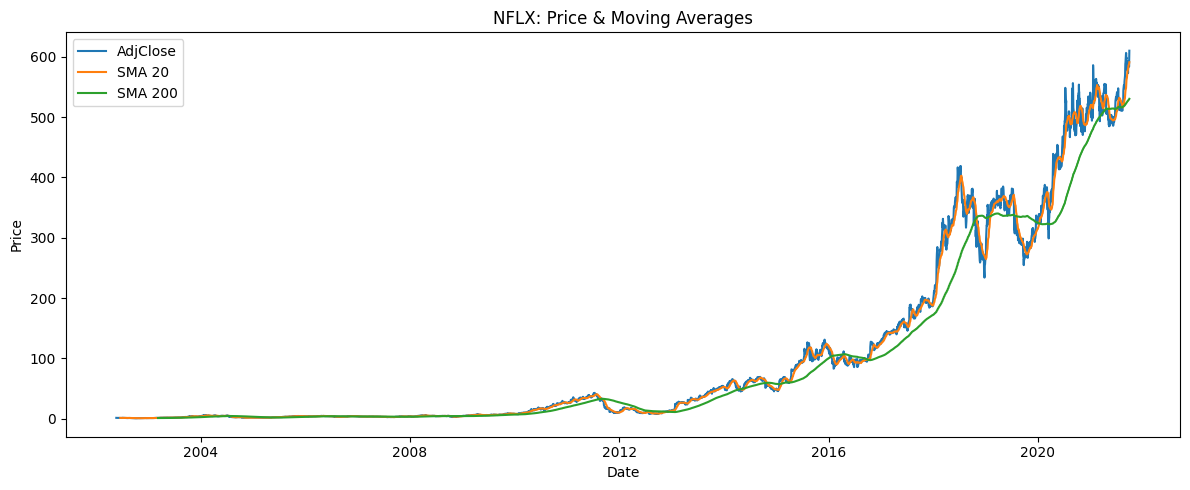

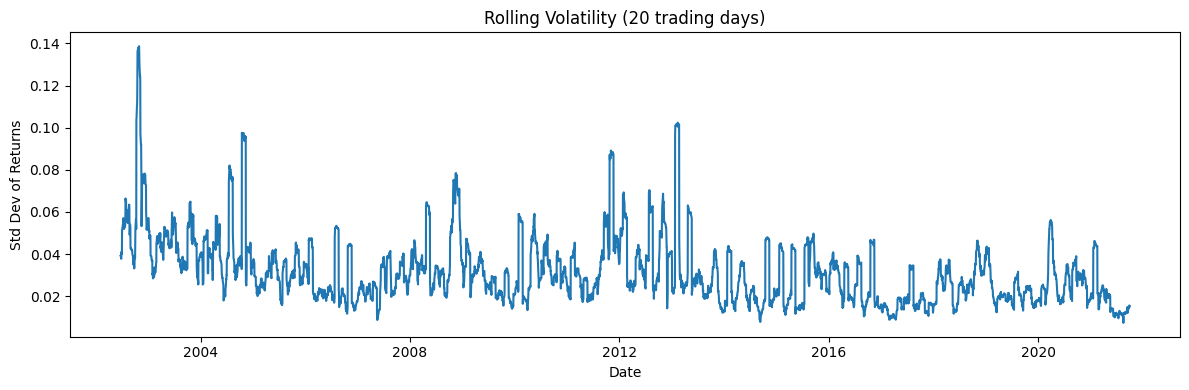

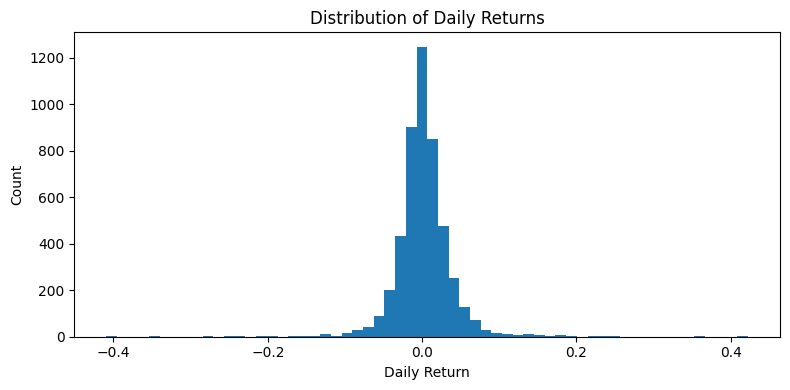

In [ ]:

# --- Visual 1: Price & Moving Averages ---
plt.figure(figsize=(12,5))
plt.plot(df_eda.index, df_eda["AdjClose"], label="AdjClose")
plt.plot(df_eda.index, df_eda["SMA_20"], label="SMA 20")
plt.plot(df_eda.index, df_eda["SMA_200"], label="SMA 200")
plt.title("NFLX: Price & Moving Averages")
plt.xlabel("Date"); plt.ylabel("Price"); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "price_ma.png"))
plt.show()

# --- Visual 2: Rolling Volatility (20d) ---
plt.figure(figsize=(12,4))
plt.plot(df_eda.index, df_eda["RollingVol_20"])
plt.title("Rolling Volatility (20 trading days)")
plt.xlabel("Date"); plt.ylabel("Std Dev of Returns"); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "rolling_vol_20.png"))
plt.show()

# --- Visual 3: Return Distribution ---
plt.figure(figsize=(8,4))
plt.hist(df_eda["Ret_close2close"].dropna(), bins=60)
plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Return"); plt.ylabel("Count"); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "return_hist.png"))
plt.show()


In [ ]:

# Correlation matrix
corr_cols = ["AdjClose","Lag1","Ret_close2close","Range_Pct","RollingVol_20"]
corr = df_eda[corr_cols].dropna().corr()
corr.to_csv(os.path.join(OUT_DIR, "correlation_matrix.csv"))
corr


,AdjClose,Lag1,Ret_close2close,Range_Pct,RollingVol_20
AdjClose,1.000000,0.999558,-0.001860,-0.234379,-0.308638
Lag1,0.999558,1.000000,-0.014612,-0.234144,-0.308745
Ret_close2close,-0.001860,-0.014612,1.000000,0.109974,0.030802
Range_Pct,-0.234379,-0.234144,0.109974,1.000000,0.477986
RollingVol_20,-0.308638,-0.308745,0.030802,0.477986,1.000000


In [ ]:

# Volume vs Big Moves (H2 proxy)
q = df_eda["Volume"].quantile([0.25, 0.5, 0.75])
df_eda["VolQuartile"] = pd.qcut(df_eda["Volume"].rank(method="first"), 4, labels=["Q1","Q2","Q3","Q4"])
agg = df_eda.groupby("VolQuartile")["BigMove"].mean().rename("Pct_BigMove").reset_index()
agg.to_csv(os.path.join(OUT_DIR, "volume_vs_bigmove.csv"), index=False)
agg


,VolQuartile,Pct_BigMove
0,Q1,0.100082
1,Q2,0.164204
2,Q3,0.284072
3,Q4,0.430681


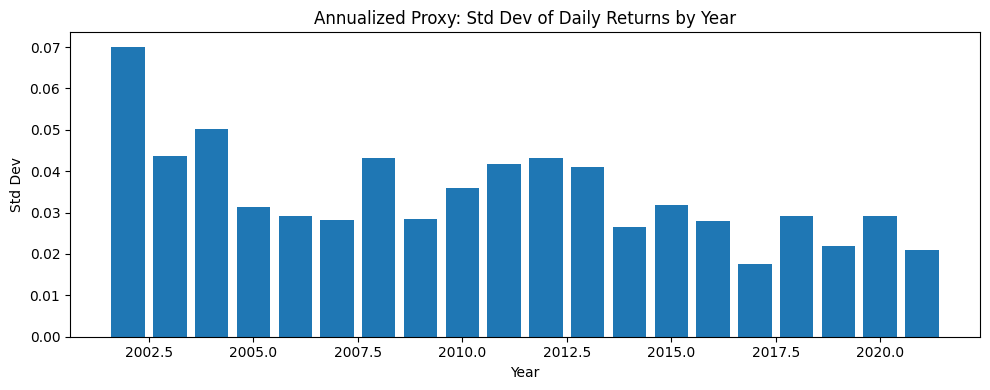

In [ ]:

# Yearly volatility comparison (H1)
yearly_vol = df_eda.groupby("Year")["Ret_close2close"].std().rename("Volatility").reset_index()
yearly_vol.to_csv(os.path.join(OUT_DIR, "yearly_volatility.csv"), index=False)

plt.figure(figsize=(10,4))
plt.bar(yearly_vol["Year"], yearly_vol["Volatility"])
plt.title("Annualized Proxy: Std Dev of Daily Returns by Year")
plt.xlabel("Year"); plt.ylabel("Std Dev"); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "yearly_volatility.png"))
plt.show()


In [ ]:

# Baseline prelim model: predict next-day level with Lag1 only
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

df_model = df_eda.dropna(subset=["AdjClose","Lag1"]).copy()
df_model["AdjClose_t+1"] = df_model["AdjClose"].shift(-1)
df_model = df_model.dropna(subset=["AdjClose_t+1"])

# Time-aware split (last ~252 days as test)
TEST_DAYS = 252 if len(df_model) > 600 else max(60, len(df_model)//5)
train_m = df_model.iloc[:-TEST_DAYS].copy()
test_m  = df_model.iloc[-TEST_DAYS:].copy()

# Naive baseline = carry-forward Lag1
naive_pred = test_m["Lag1"].values
y_test = test_m["AdjClose_t+1"].values

# Simple Linear Regression on Lag1
lr = LinearRegression()
lr.fit(train_m[["Lag1"]], train_m["AdjClose_t+1"])
lr_pred = lr.predict(test_m[["Lag1"]])

def rmse(a,b):
    import numpy as np
    from sklearn.metrics import mean_squared_error
    return np.sqrt(mean_squared_error(a,b))

metrics = pd.DataFrame([
    {"Model":"Naive","RMSE":rmse(y_test, naive_pred),"MAE":mean_absolute_error(y_test, naive_pred),"R2":r2_score(y_test, naive_pred)},
    {"Model":"LinReg_Lag1","RMSE":rmse(y_test, lr_pred),"MAE":mean_absolute_error(y_test, lr_pred),"R2":r2_score(y_test, lr_pred)},
])

metrics.to_csv(os.path.join(OUT_DIR, "prelim_metrics.csv"), index=False)
metrics


,Model,RMSE,MAE,R2
0,Naive,15.192151,10.724089,0.747132
1,LinReg_Lag1,15.176626,10.657922,0.747649


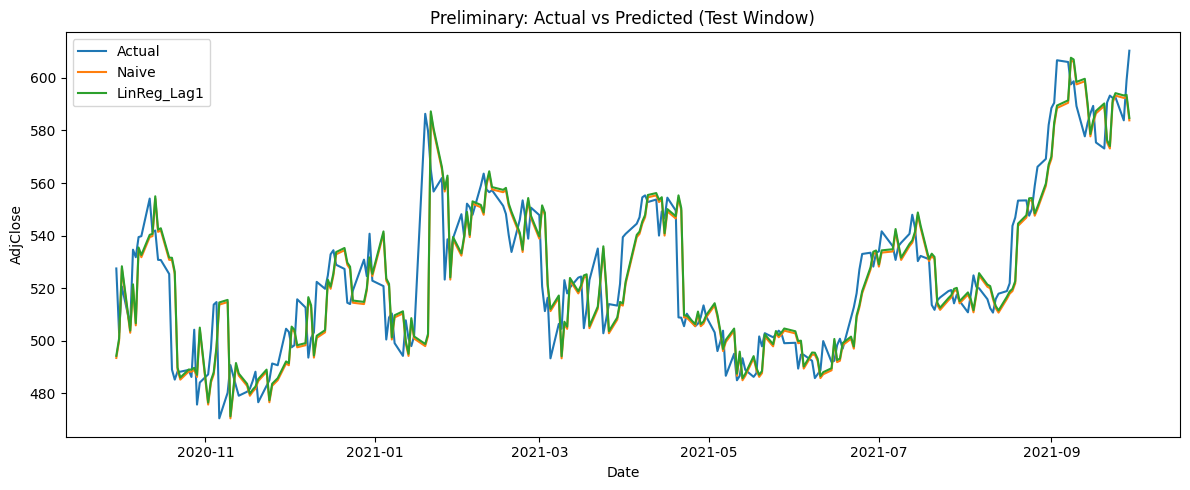

In [ ]:

# Plot: Actual vs Pred (test window)
plt.figure(figsize=(12,5))
plt.plot(test_m.index, y_test, label="Actual")
plt.plot(test_m.index, naive_pred, label="Naive")
plt.plot(test_m.index, lr_pred, label="LinReg_Lag1")
plt.title("Preliminary: Actual vs Predicted (Test Window)")
plt.xlabel("Date"); plt.ylabel("AdjClose"); plt.legend(); plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "prelim_actual_vs_pred.png"))
plt.show()


In [ ]:

# Exports for Tableau (Part 2 visuals)
# - Clean OHLCV
# - EDA features
# - Aggregations (yearly vol, volume vs big moves)
# - Predictions long-form for prelim model
pred_df = pd.DataFrame({
    "Date": test_m.index,
    "Actual": y_test,
    "Naive": naive_pred,
    "LinReg_Lag1": lr_pred
}).set_index("Date")

pred_long = pred_df.reset_index().melt(id_vars="Date", var_name="Series", value_name="AdjClose")
pred_df.to_csv(os.path.join(OUT_DIR, "prelim_actual_pred_wide.csv"))
pred_long.to_csv(os.path.join(OUT_DIR, "prelim_actual_pred_long.csv"), index=False)

print("Tableau exports written to:", OUT_DIR)


Tableau exports written to: part2_redo_outputs


In [ ]:
!zip -r part2_redo_outputs.zip part2_redo_outputs


  adding: part2_redo_outputs/ (stored 0%)
  adding: part2_redo_outputs/prelim_metrics.csv (deflated 23%)
  adding: part2_redo_outputs/correlation_matrix.csv (deflated 58%)
  adding: part2_redo_outputs/prelim_actual_pred_long.csv (deflated 75%)
  adding: part2_redo_outputs/prelim_actual_vs_pred.png (deflated 2%)
  adding: part2_redo_outputs/yearly_volatility.csv (deflated 49%)
  adding: part2_redo_outputs/data_dictionary.csv (deflated 54%)
  adding: part2_redo_outputs/prelim_actual_pred_wide.csv (deflated 64%)
  adding: part2_redo_outputs/rolling_vol_20.png (deflated 4%)
  adding: part2_redo_outputs/price_ma.png (deflated 6%)
  adding: part2_redo_outputs/return_hist.png (deflated 19%)
  adding: part2_redo_outputs/volume_vs_bigmove.csv (deflated 15%)
  adding: part2_redo_outputs/eda_features.csv (deflated 62%)
  adding: part2_redo_outputs/yearly_volatility.png (deflated 21%)
  adding: part2_redo_outputs/clean_ohlcv.csv (deflated 71%)


In [ ]:
from google.colab import files
files.download("part2_redo_outputs.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>